In [1]:
%matplotlib inline

from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle
from itertools import combinations
from scipy.special import comb

In [2]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    """
    Returns the literal that appears in the most number of clauses
    """
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    """
    Returns the literal that appears most in the smallest clauses
    """
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    """
    Combines MAXO and MOMS count statistics from above and chooses the literal that appears most between them
    """
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    """
    Jeroslow-Wang Rule
    """
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def jw_2(literal_clauseNum, clauseNum_clause):
    """
    2-sided JW rule. See Heutistics folder
    """
    
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in list(literal_score.items()):
        other_literal = switch_literal(literal)
        total_score = score + literal_score[other_literal]
        
        if total_score > max_score:
            max_score = score
            max_lit = literal if score >= literal_score[other_literal] else other_literal
            
    return max_lit, max_score


def bohm(literal_clauseNum, clauseNum_clause):
    """
    See Heuristics folder. Lexicographic order of the vector (H1(x), H2(x), ..., Hn(x)) means we first choose highest H1(x)
    variable. When tied we then choose amongst tied variable highest H2 variable. When tied then H3 and so on.
    
    We've had to manage edge cases here but don't mention that in report. Only give formula from paper
    """
    pos_literal_count = defaultdict(lambda: [0, 0, 0])  # This default initialisation only works for 3 SAT
    neg_literal_count = defaultdict(lambda: [0, 0, 0])
    
    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                neg_literal_count[literal][len(clause)-1] += 1
        else:
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                pos_literal_count[literal][len(clause)-1] += 1
                
    final_count = []
    # Sometimes we only have negative literals left. So then we just use those
    for literal, pos_counts in (pos_literal_count.items() or neg_literal_count.items()):
        other_literal = switch_literal(literal)
        
        if literal.startswith('-'):
            # pos_literal_counts is empty. So literal and pos_counts actually are neg_literal_counts
            neg_counts = pos_literal_count[other_literal]
        else:
            # pos_literal_counts isn't empty. So continue as normal
            neg_counts = neg_literal_count[other_literal]
        
        final_count.append(([max(p, n) + 2 * min(p, n) for p, n in zip(pos_counts, neg_counts)], literal))
            
    final_count.sort(reverse=True)
    score_vector, literal = final_count[0]
    other_literal = switch_literal(literal)
    
    if literal.startswith('-'):
        neg_literal = literal
        pos_literal = other_literal
    else:
        neg_literal = other_literal
        pos_literal = literal
    
    # Since the score for positive and negative literal is the same, choose one which the highest overall score
    if sum(pos_literal_count[pos_literal]) >= sum(neg_literal_count[neg_literal]):
        literal = pos_literal
    else:
        literal = neg_literal
    
    return literal, score_vector
    

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw_2':
        literal, _ = jw_2(literal_clauseNum, clauseNum_clause)
    elif algo == 'bohm':
        literal, _ = bohm(literal_clauseNum, clauseNum_clause)
    

    return literal

In [7]:
# Methods that are used by the Env class to get state features

def number_of_clauses(literal_clauseNum):
    """ Returns the number of clauses each of the literal is present in """
    ans = np.zeros(actions)
    for literal, clauseNums in literal_clauseNum.items():
        ans[LIT_IDX[literal]] = len(clauseNums)
    return ans


def number_of_horn_clauses(clauseNum_clause):
    """ Returns the number of horn clauses each literal is present in """
    ans = np.zeros(actions)
    for clause in clauseNum_clause.values():
        if len(clause) == 0:
            continue
        pos_literals = list(filter(lambda x: not x.startswith('-'), clause))
        if len(pos_literals) == 1:
            ans[LIT_IDX[pos_literals[0]]] += 1
            
    return ans
        

def pos_neg_ratio(literal_clauseNum):
    ans = np.zeros(actions)
    
    for literal, clauseNums in literal_clauseNum.items():
        opposite_literal = switch_literal(literal)
        if opposite_literal in literal_clauseNum and len(literal_clauseNum[opposite_literal]) > 0:
            ratio = len(clauseNums) / len(literal_clauseNum[opposite_literal])
        else:
            ratio = len(clauseNums)
            
        ans[LIT_IDX[literal]] = ratio
        
    return ans


def CVIG(literal_clauseNum, clauseNum_clause):
    """
    Caluse-variable incidence graph. We create a bipartite graph (a matrix) with literals in rows and clauses in columns.
    See Features_2 PDF file.
    """
    
    clauseNum_index_mapping = {}
    
    for i, clauseNum in enumerate(clauseNum_clause):
        clauseNum_index_mapping[clauseNum] = i
        
    if len(clauseNum_clause) == 0:
        return np.zeros((len(LIT_IDX), 1))
    
    graph = np.zeros((len(LIT_IDX), len(clauseNum_index_mapping)))
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            graph[LIT_IDX[literal]] [clauseNum_index_mapping[clauseNum]] = 1/len(clauseNums)
    
    return graph


def VIG(literal_clauseNum, clauseNum_clause):
    """
    Variable incidence graph.
    """
    if len(clauseNum_clause) == 0:
        return np.zeros((actions, actions))
    
    graph = np.zeros((actions, actions))
    
    for clause in clauseNum_clause.values():
        if len(clause) < 2:
            continue
        for x, y in combinations(clause, 2):
            w = 1 / (comb(len(clause), 2))  # Try combinations with replacement to add self-loops
            graph[LIT_IDX[x]][LIT_IDX[y]] = w
            graph[LIT_IDX[y]][LIT_IDX[x]] = w
            
    return graph

In [4]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        # self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}
        # self.action_penalty = {0: 0, 1: 0, 2: 0, 3: 0, 4: -1, 5: -1}  # Penalty to give each action
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses = number_of_clauses(literal_clauseNum)
        num_horn_clauses = number_of_horn_clauses(clauseNum_clause)
        
        pn_ratio = pos_neg_ratio(literal_clauseNum)
        
        vig_graph = VIG(literal_clauseNum, clauseNum_clause)
        vig_mean, vig_var = np.mean(vig_graph, axis=0), np.var(vig_graph, axis=0)
        
        cvig_graph = CVIG(literal_clauseNum, clauseNum_clause)
        cvig_mean, cvig_var = np.mean(cvig_graph, axis=1), np.var(cvig_graph, axis=1)
        
        state_matrix = list(zip(num_clauses, num_horn_clauses, pn_ratio, vig_mean, vig_var, cvig_mean, cvig_var))
#         state_matrix = list(zip(num_clauses, num_horn_clauses, cvig_mean, cvig_var))
#         state_matrix = list(zip(num_clauses, num_horn_clauses))
        return np.array(state_matrix)  # Returns a 2D array of the state matrix
    
        
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses_start = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_start += 1
            else:
                # This is reached when we reached an UNSAT state in previous step and popped off another UNSAT from the stack
                isEmpty = len(self.stack) == 0
                if not isEmpty:
                    self.state = self.stack.pop()
                return None, -1, isEmpty
        
        literal = literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='bohm')
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
            
        # Set new state
        self.state = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
        # Check that setting chosen to False hasn't made any empty clauses
        valid = True
        for clause in clauseNum_clause_F.values():
            if len(clause) == 0:
                valid = False
        
        # Add new state to stack
        if valid:
            self.stack.append((literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F))
        
        
        if clauseNum_clause_T == {} or clauseNum_clause_F == {}:  # We have satisfied
#             print("INITIAL")
            return None, 1, True
        
        
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return None, -1, isEmpty
        
        if clauseNum_clause == {}:
#             print("UNIT PROP")
            return None, 1, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
            
        if clauseNum_clause == {}:
#             print("PLE")
            return None, 1, True
        
        num_clauses_end = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_end += 1
        
        if num_clauses_start > 0:
            fraction_of_clauses_removed = (num_clauses_start - num_clauses_end)/num_clauses_start
        else:
            fraction_of_clauses_removed = 0
        
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
                
        return None, -1 + fraction_of_clauses_removed, False

In [5]:
def spread(vals):
    vals_range = vals - np.mean(vals)
    return np.abs(np.min(vals_range)) + np.abs(np.max(vals_range))

def VAR(mat):
    return np.array([spread(mat[:, cols]) for cols in range(mat.shape[1])])

In [8]:
numVars = 20
LITERALS = list(range(-numVars, 0))
pos_lit = list(range(1, numVars+1))
LITERALS.extend(pos_lit)
LIT_IDX = {}  # Global mapping between literal and its position in the action space
IDX_LIT = {}  # Global mapping between its position in the action space and literal

for index, var in enumerate(LITERALS):
    LIT_IDX[str(var)] = index
    IDX_LIT[index] = str(var)

actions = len(LITERALS) # numVars*2 + 1       # Number of actions available to use by the agent
state_space = 7  # Number of variables we return as state of environment. Used to initialise Scaler and SGD in Estimator


directory = '../Tests/CNFGEN_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))
files = files[:1000]

print("Number of files:", len(files))

states = []

for filepath in files:
    env = Env(filepath)
    states.append(env.reset())
    
    while True:
        _, _, done = env.step(5)
        states.append(env.get_state())
        
        if done:
            break

states = np.array(states)
print("Done")

Number of files: 1000
Done


In [9]:
print(states.shape)
states = np.reshape(states, (-1, state_space))
states.shape

(11625, 40, 7)


(465000, 7)

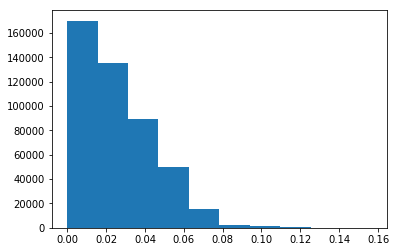

In [10]:
z = plt.hist(states[:, 4])

[3.88895054e+00 5.81313978e-01 9.42730629e-01 6.07574910e-02
 2.42512814e-02 1.33242479e-02 3.64922580e-03]


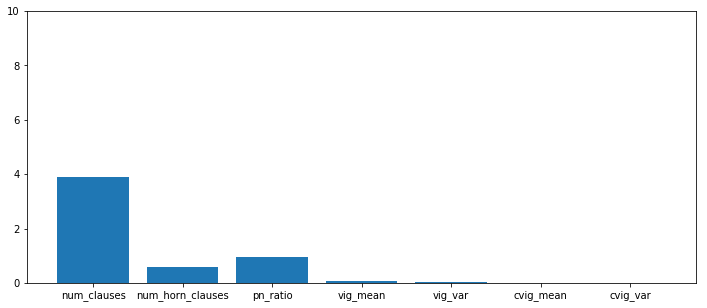

In [11]:
plt.figure(figsize=(12, 5))

mean = np.mean(states, axis=0)
labels = ['num_clauses', 'num_horn_clauses', 'pn_ratio', 'vig_mean', 'vig_var', 'cvig_mean', 'cvig_var']
plt.bar(labels, mean)
plt.ylim(0, 10)


print(mean)

[18.          9.         15.          0.25        0.15666667  1.
  0.25      ]


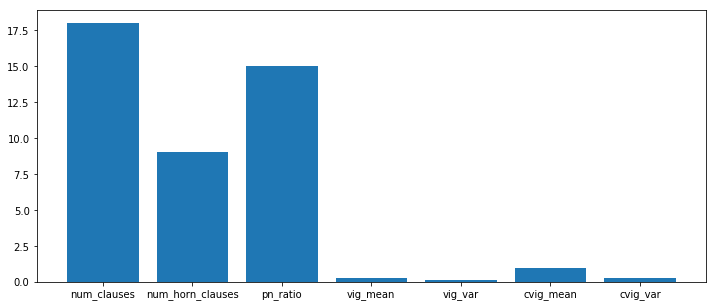

In [12]:
plt.figure(figsize=(12, 5))

var = VAR(states)  # np.var(states, axis=0)
plt.bar(labels, var)
# plt.ylim(0, 1)


print(var)

[462.8498055146038, 1548.2166837457596, 1591.1225902417725, 411.4718954373334, 646.0139748002954, 7505.114050874644, 6850.768189848463]


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

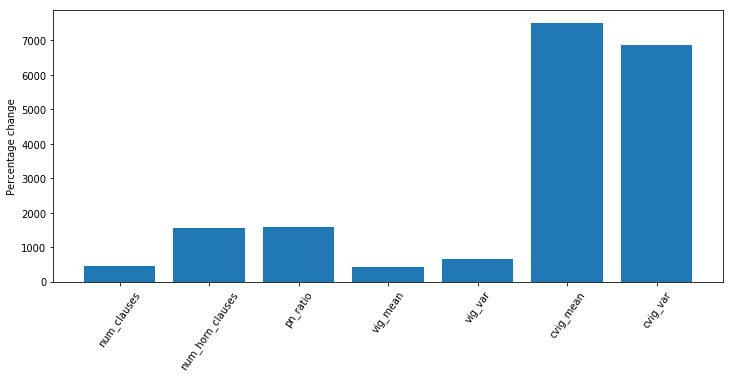

In [13]:
from matplotlib2tikz import save as tikz_save

plt.figure(figsize=(12, 5))

percent_vary = [(v / m) * 100 for m, v in zip(list(mean), list(var))]
print(percent_vary)
plt.bar(labels, percent_vary)
# plt.ylim(0, 50)
plt.ylabel("Percentage change")
plt.xticks(rotation=55)

# tikz_save('FS_spread.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')

In [112]:
# Given the mean and variance, we vary each dimension along all possible values to see what policy it follows

import time

def policy_use(mean, var, estimator):
    counts = [0]*6
    count = 0
    length = 4

    s = time.time()
    for i0 in np.linspace(mean[0]-var[0]/2, mean[0]+var[0]/2, length):
        for i1 in np.linspace(mean[1]-var[1]/2, mean[1]+var[1]/2, length):
    #         for i2 in np.linspace(mean[2]-var[2]/2, mean[2]+var[2]/2, length):
                for i3 in np.linspace(mean[3]-var[3]/2, mean[3]+var[3]/2, length):
                    for i4 in np.linspace(mean[4]-var[4]/2, mean[4]+var[4]/2, length):
                        for i5 in np.linspace(mean[5]-var[5]/2, mean[5]+var[5]/2, length):
                            for i6 in np.linspace(mean[6]-var[6]/2, mean[6]+var[6]/2, length):
                                for i7 in np.linspace(mean[7]-var[7]/2, mean[7]+var[7]/2, length):
                                    state = [i0, i1, i3, i4, i5, i6, i7]
                                    qvals = estimator.predict(state)
                                    counts[np.argmax(qvals)] += 1

                                    count += 1
                                    if count % 1000000 == 0:
                                        print(count)
                                        
    return counts
                 
s = time.time()
counts = policy_use(mean, var, estimator)
e = time.time()
print("Time taken:", round(e-s, 2))

Time taken: 3.92


In [97]:
%debug

> /home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/sklearn/preprocessing/data.py(692)transform()
    690         else:
    691             if self.with_mean:
--> 692                 X -= self.mean_
    693             if self.with_std:
    694                 X /= self.scale_

ipdb> u
> <ipython-input-91-1e3fd9a8b3a5>(31)predict()
     29     def predict(self, state):
     30         state_feature = self.featurize_state(state)
---> 31         state_feature = self.scaler.transform([state_feature]) # Returns a 2D array
     32         return np.array([m.predict(state_feature)[0] for m in self.models])
     33 

ipdb> state
[20.098993288590606, 0.2697546849315706, -1.2780441603277668, -0.10132968055451358, -0.007936740845204869, -0.016400194459147012, 0.010079803243038837, 0.005096382974455801]
ipdb> d
> /home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/sklearn/preprocessing/data.py(692)transform()
    690         else:
    691             if self.with_mean:
--> 692  

In [113]:
counts

[5836, 44, 4268, 6200, 36, 0]

In [14]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print("Max VIF:", max(vif))
            print('dropping \'' + str(X[variables].columns[maxloc]) + '\' at index: ' + str(maxloc))
            print()
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [18]:
calculate_vif_(pd.DataFrame(states), 10)
print("Done")

Max VIF: 115.3668458196467
dropping '3' at index: 3

Remaining variables:
Int64Index([0, 1, 2, 4, 5, 6], dtype='int64')
Done


In [117]:
#               0                      1            2           3          4             5          6
labels =    ['num_clauses', 'num_horn_clauses', 'pn_ratio', 'vig_mean', 'vig_var', 'cvig_mean', 'cvig_var']
# The below works well
remaining = ['num_var', 'c_v_ratio', 'cvig_mean', 'cvig_var']  # Indices 0, 1, 4, 5

"""
When trying other metrics such as using pn_ratio and vig instead of cvig and vig incl. cig etc. All produced worse results.

Removing any of these features also produced worse results.

Using horn_clause as a feature and looking at the SGD weight-age for this, it is very low. So this is redundant. Similar for 
other Horn clause based metrics
"""

> <ipython-input-116-6508c3874178>(14)calculate_vif_()
     12         maxloc = vif.index(max(vif))
     13         if max(vif) > thresh:
---> 14             print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
     15             del variables[maxloc]
     16             dropped=True

ipdb> maxloc
6
ipdb> X[variables].columns[maxloc]
6
ipdb> q


In [92]:
with open('Metrics/SATLIB_50_action_penalty.pickle', 'rb') as fin:
    episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_reward_rand, episode_length_rand = pickle.load(fin)